# Data Cleaning - Aggregated Airbnb Listings

## Introduction

In the following notebook, I will be cleaning an aggregation of Airbnb listings data. This data pertains to the San Francisco area and consists of calendar data from 10/2018 through 12/2019.

The aggregation source code can be found [here](https://github.com/KishenSharma6/Airbnb-SF_ML_-_Text_Analysis/blob/master/Airbnb%20Raw%20Data%20Aggregation.ipynb)

Raw data can be found [here](https://github.com/KishenSharma6/Airbnb-SF_ML_-_Text_Analysis/tree/master/Data/01_Raw/SF%20Airbnb%20Raw%20Data)

**Read in necessary libraries**

In [1]:
#Read in libraries
import dask.dataframe as dd
import swifter

import pandas as pd
import pandas_profiling

import re

import numpy as np
from scipy import stats

import matplotlib.pyplot as plt

**Set Additional Settings for Notebook**

In [2]:
#supress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Increase number of columns and rows displayed by Pandas
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',200)

**Read in Data**

In [3]:
#Set path to get aggregated listings data
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Air BnB - SF\Data\01_Raw\SF Airbnb Raw Data\SF Airbnb Raw Data - Aggregated\01_04_2020_Listings_Raw_Aggregated.csv'

#list columns with date information to parse
dates = ['calendar_last_scraped', 'calendar_updated', 'first_review', 'host_since', 'last_review']

#Read in Airbnb listings Data
listings = pd.read_csv(path,index_col=0, low_memory=False, sep=',', parse_dates=dates)


## Pandas Profiling Report

In [ ]:
#Set path to write Pandas Profiling Report
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Air BnB - SF\Visualizations\Pandas Reports'

In [4]:
#Create Pandas Profiling Report for listings data
profile = listings.profile_report(title='Airbnb Listings Report')

#Write profile to an HTML file
profile.to_file(path + output_file="/Airbnb Listings Report.html")

#Capture rejected variables
rejected_variables = profile.get_rejected_variables(threshold=0.9)

#View variables that were rejected
print('Variables rejected for having a greater collinearity than .9:', rejected_variables)

In [5]:
#Variables rejected for having a collinearity > .9
rejected = ['availability_60', 'availability_90', 'calculated_host_listings_count_entire_homes', 'country_code', 
'host_total_listings_count', 'last_scraped', 'maximum_minimum_nights', 'maximum_nights', 
'maximum_nights_avg_ntm', 'minimum_maximum_nights', 'minimum_minimum_nights', 'minimum_nights', 'minimum_nights_avg_ntm']

In [6]:
#View pandas profile for listings data
profile

# Data Cleaning

**Preview data in original format**

In [7]:
#Print original listings shape
print('Original listings shape:',listings.shape)

#View listings head
display(listings.head())

Original listings shape: (98796, 106)


,access,accommodates,amenities,availability_30,availability_365,availability_60,availability_90,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,calendar_last_scraped,calendar_updated,cancellation_policy,city,cleaning_fee,country,country_code,description,experiences_offered,extra_people,first_review,guests_included,has_availability,host_about,host_acceptance_rate,host_has_profile_pic,host_id,host_identity_verified,host_is_superhost,host_listings_count,host_location,host_name,host_neighbourhood,host_picture_url,host_response_rate,host_response_time,host_since,host_thumbnail_url,host_total_listings_count,host_url,host_verifications,house_rules,id,instant_bookable,interaction,is_business_travel_ready,is_location_exact,jurisdiction_names,last_review,last_scraped,latitude,license,listing_url,longitude,market,maximum_maximum_nights,maximum_minimum_nights,maximum_nights,maximum_nights_avg_ntm,medium_url,minimum_maximum_nights,minimum_minimum_nights,minimum_nights,minimum_nights_avg_ntm,monthly_price,name,neighborhood_overview,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,notes,number_of_reviews,number_of_reviews_ltm,picture_url,price,property_type,require_guest_phone_verification,require_guest_profile_picture,requires_license,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,scrape_id,security_deposit,smart_location,space,square_feet,state,street,summary,thumbnail_url,transit,weekly_price,xl_picture_url,zipcode
0,*Full access to patio and backyard (shared wit...,3,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Pets liv...",0,77,0,1,1.0,Real Bed,1.0,2.0,1,1.0,0.0,0.0,2019-04-03,a week ago,moderate,San Francisco,$100.00,United States,US,New update: the house next door is under const...,none,$25.00,2009-07-23,2,t,We are a family with 2 boys born in 2009 and 2...,NaN,t,1169,t,t,1.0,"San Francisco, California, United States",Holly,Duboce Triangle,https://a0.muscache.com/im/pictures/efdad96a-3...,100%,within an hour,2008-07-31,https://a0.muscache.com/im/pictures/efdad96a-3...,1.0,https://www.airbnb.com/users/show/1169,"['email', 'phone', 'facebook', 'reviews', 'kba']",* No Pets - even visiting guests for a short t...,958,t,A family of 4 lives upstairs with their dog. N...,f,t,"{""SAN FRANCISCO""}",2019-03-16,2019-04-03,37.76931,STR-0001256,https://www.airbnb.com/rooms/958,-122.43386,San Francisco,30.0,1.0,30,30.0,NaN,30.0,1.0,1,1.0,"$4,200.00","Bright, Modern Garden Unit - 1BR/1B",*Quiet cul de sac in friendly neighborhood *St...,Duboce Triangle,Western Addition,NaN,Due to the fact that we have children and a do...,183,51.0,https://a0.muscache.com/im/pictures/b7c2a199-4...,$170.00,Apartment,f,f,t,10.0,10.0,10.0,10.0,10.0,97.0,10.0,1.55,Entire home/apt,2.019040e+13,$100.00,"San Francisco, CA","Newly remodeled, modern, and bright garden uni...",NaN,CA,"San Francisco, CA, United States",New update: the house next door is under const...,NaN,*Public Transportation is 1/2 block away. *Ce...,"$1,120.00",NaN,94117
1,"Our deck, garden, gourmet kitchen and extensiv...",5,"{Internet,Wifi,Kitchen,Heating,""Family/kid fri...",0,0,0,0,1.0,Real Bed,2.0,3.0,1,1.0,0.0,0.0,2019-04-03,4 months ago,strict_14_with_grace_period,San Francisco,$100.00,United States,US,We live in a large Victorian house on a quiet ...,none,$0.00,2009-05-03,2,t,Philip: English transplant to the Bay Area and...,NaN,t,8904,t,f,2.0,"San Francisco, California, United States",Philip And Tania,Bernal Heights,https://a0.muscache.com/im/users/8904/profile_...,80%,within a day,2009-03-02,https://a0.muscache.com/im/users/8904/profile_...,2.0,https://www.airbnb.com/users/show/8904,"['email', 'phone', 'reviews', 'kba', 'work_ema...","Please respect the house, the art work, the fu...",5858,f,NaN,

### Column Removal

**Removing rejected columns from Pandas Report**

These columns have a correlation of over 90% with another variable in the dataset.

In [8]:
#Remove collinear columns from listings
listings.drop(columns = rejected, inplace = True)

#Updated listings shape
print('Updated listings shape:', listings.shape)

Updated listings shape: (98796, 93)


**Removing redundant columns**

Columns city, street, and smart_location appear to encode the same information. Columns neighbourhood and neighbourhood_cleansed also appear to do the same. 

Keeping city and neighbourhood_cleansed columns, dropping the others.

In [9]:
#Cols to drop
cols = ['street', 'smart_location','neighbourhood']

#Dropping redundant columns
listings.drop(columns=cols, inplace=True)

#Updated listings shape
print('Updated listings shape:', listings.shape)

Updated listings shape: (98796, 90)


**Remove columns with homogenous values**

In [10]:
#Capture columns with homogeneous values and store as list in cols
cols = list(listings.columns[listings.nunique() <= 1])

#Drop cols
listings.drop(columns=cols, axis = 1, inplace=True)

#Updated listings shape
print('Updated listings shape:', listings.shape)

Updated listings shape: (98796, 82)


**Check for additional columns with mostly homogenous values**

In [11]:
#Capture columns with homogeneous values and store as list in cols
print(listings.columns[listings.nunique() <= 2])

#Per Pandas Report, state and country are not boolean values
#Investigating rows where listings.country == 'Mexico'
listings[listings.country == 'Mexico']

Index(['country', 'host_has_profile_pic', 'host_identity_verified',
       'host_is_superhost', 'instant_bookable', 'is_location_exact',
       'jurisdiction_names', 'market', 'require_guest_phone_verification',
       'require_guest_profile_picture', 'requires_license'],
      dtype='object')


,access,accommodates,amenities,availability_30,availability_365,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,calendar_last_scraped,calendar_updated,cancellation_policy,city,cleaning_fee,country,description,extra_people,first_review,guests_included,host_about,host_has_profile_pic,host_id,host_identity_verified,host_is_superhost,host_listings_count,host_location,host_name,host_neighbourhood,host_picture_url,host_response_rate,host_response_time,host_since,host_thumbnail_url,host_url,host_verifications,house_rules,id,instant_bookable,interaction,is_location_exact,jurisdiction_names,last_review,latitude,license,listing_url,longitude,market,maximum_maximum_nights,monthly_price,name,neighborhood_overview,neighbourhood_cleansed,notes,number_of_reviews,number_of_reviews_ltm,picture_url,price,property_type,require_guest_phone_verification,require_guest_profile_picture,requires_license,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,scrape_id,security_deposit,space,square_feet,state,summary,transit,weekly_price,zipcode
4767,NaN,6,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,E...",0,0,3.5,Real Bed,3.0,4.0,1,0.0,0.0,2019-04-03,today,super_strict_60,San Francisco,$0.00,Mexico,ONEFINESTAY is proud to present this 3 bedroom...,$0.00,NaN,6,"Hi, \r\n\r\nMy name is Sally and I am part of ...",t,156158778,f,f,458.0,"London, England, United Kingdom",Sally,Battersea,https://a0.muscache.com/im/pictures/user/e7869...,100%,within an hour,2017-10-25,https://a0.muscache.com/im/pictures/user/e7869...,https://www.airbnb.com/users/show/156158778,"['email', 'phone', 'work_email']",Pets not allowed. Check in from 16:00 to 16:00.,23298702,t,NaN,f,NaN,NaN,37.795740,NaN,https://www.airbnb.com/rooms/23298702,-122.425660,San Francisco,1125.0,NaN,Three Bridges Penthouse by ONEFINESTAY,NaN,Pacific Heights,Home Truths: - There is a dedicated elevator ...,0,0.0,https://a0.muscache.com/im/pictures/f00cf518-5...,"$8,000.00",Apartment,f,f,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,2.019040e+13,"$1,500.00","Included amenities: Wifi, iPhone, Welcome Pack...",NaN,NaN,ONEFINESTAY is proud to present this 3 bedroom...,NaN,NaN,94109
20223,NaN,6,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,E...",10,25,3.5,Real Bed,3.0,4.0,2,NaN,NaN,2018-12-06,today,super_strict_60,San Francisco,$0.00,Mexico,ONEFINESTAY is proud to present this 3 bedroom...,$0.00,NaN,6,"Hi, \r\n\r\nMy name is Sally and I am part of ...",t,156158778,f,f,419.0,"London, England, United Kingdom",Sally,Battersea,https://a0.muscache.com/im/pictures/user/e7869...,100%,within an hour,2017-10-25,https://a0.muscache.com/im/pictures/user/e7869...,https://www.airbnb.com/users/show/156158778,"['email', 'phone', 'work_email']",Pets not allowed. Check in from 16:00 to 16:00.,23298702,t,NaN,f,NaN,NaN,37.795744,NaN,https://www.airbnb.com/rooms/23298702,-122.425657,San Francisco,NaN,NaN,Three Bridges Penthouse by ONEFINESTAY,NaN,Pacific Heights,Home Truths: - There is a dedicated elevator ...,0,NaN,https://a0.muscache.com/im/pictures/f00cf518-5...,"$8,000.00",Apartment,f,f,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,2.018121e+13,"$1,500.00","Included amenities: Wifi, iPhone, Welcome Pack...",NaN,NaN,ONEFINESTAY is proud to present this 3 bedroom...,NaN,NaN,94109.0
35719,NaN,6,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,E...",7,7,3.5,Real Bed,3.0,4.0,1,0.0,0.0,2019-02-01,today,super_strict_60,San Francisco,$0.00,Mexico,ONEFINESTAY is proud to present this 3 bedroom...,$0.00,NaN,6,"Hi, \r\n\r\nMy name is Sally and I am part of ...",t,156158778,f,f,394.0,"London, England, United Kingdom",Sally,Battersea,https://a0.muscache.com/im/pictures/user/e7869...,97%,within an hour,2017-10-25,https://a0.muscache.com/im/pictures/user/e7869...,https://www.airbnb.com/users/sh

Rows with Mexico in the country column belong to the same host. This listing is in Pacifica Heights, a neighborhood in San Francisco. We can remove country and state column for containing mostly homogenous values.

In [12]:
#Dropping country column
listings.drop(columns=['country','state'], inplace = True)

#Updated listings shape
print('Updated listings shape:', listings.shape)

Updated listings shape: (98796, 80)


**Remove columns with majority NA values**

Columns with greater than 30% missing values will be removed.

In [13]:
#Calculate which columns have mostly NA values
print(listings.isnull().mean().sort_values(ascending=False).head(15))

square_feet               0.983188
monthly_price             0.854286
weekly_price              0.852373
notes                     0.381635
license                   0.363213
access                    0.346107
interaction               0.327432
transit                   0.293969
house_rules               0.264302
neighborhood_overview     0.261569
host_about                0.241184
security_deposit          0.204067
review_scores_value       0.202984
review_scores_checkin     0.202943
review_scores_location    0.202943
dtype: float64


Keeping weekly_price and monthly_price, missing value would indicate that the listing is unavailable for use of over 7 or 30 days respectively

In [14]:
#Store weekly_price and monthly_price
keep = listings[['weekly_price', 'monthly_price']]

#Dropping columns with more than 30% values missing
listings= listings[listings.columns[(listings.isnull().mean() < .30 )]]

#Concatenate keep cols back into listings
listings = pd.concat([listings, keep], axis=1)

#Updated listings shape
print('Updated listings shape:', listings.shape)

Updated listings shape: (98796, 75)


**Removing columns containing URL data**

URL columns contain only url link to images, which is not pertinent to our analysis.

In [15]:
#Drop columns containing URL's
listings = listings[listings.columns.drop(list(listings.filter(regex='url$')))]

#Updated listings shape
print('Updated listings shape:', listings.shape)

Updated listings shape: (98796, 70)


### Column Specific Cleaning

Cleaning specific columns in listings data in which there were specific value issues spotted in the Pandas Profiling report.

**String Formatting**

In [16]:
#Create list of cols that contain $%,{}[]"'
cols = ['cleaning_fee','extra_people','price','host_response_rate','security_deposit',
        'host_verifications','amenities','monthly_price', 'weekly_price']

#Remove $%,{}[]"'
listings[cols] = listings[cols].replace('[$,%{}\"\'\[\]]', ' ', regex=True)

#Remove white space between numerics
listings[cols] = listings[cols].replace('(?<=\d)\s+(?=\d)', '', regex=True)

#Check
listings[cols].head(3)

,cleaning_fee,extra_people,price,host_response_rate,security_deposit,host_verifications,amenities,monthly_price,weekly_price
0,100.00,25.00,170.00,100,100.00,email phone facebook reviews kba,TV Cable TV Internet Wifi Kitchen Pets liv...,4200.00,1120.00
1,100.00,0.00,235.00,80,NaN,email phone reviews kba work_ema...,Internet Wifi Kitchen Heating Family/kid fri...,5500.00,1600.00
2,50.00,12.00,65.00,100,200.00,email phone reviews jumio govern...,TV Internet Wifi Kitchen Free street parking...,1685.00,485.00


**Mapping Booleans**

There are several columns that contain strings 't' and 'f' to signify True and False. I will be updating these strings with the appropriate boolean values.

In [17]:
#List of columns to convert t's to 1's and f's to 0's
cols = ['host_has_profile_pic', 'host_identity_verified', 'host_is_superhost','instant_bookable','is_location_exact',
       'require_guest_phone_verification','require_guest_profile_picture','requires_license']

#Strip white space in strings
listings[cols] = listings[cols].apply(lambda x: x.str.strip())

#Create dictionary to map True and False
mymap = {'t':True, 'f':False}

#Replace t's and f's
listings[cols]=listings[cols].applymap(lambda s: mymap.get(s) if s in mymap else s)

#Fill missing values with a False
listings[cols] = listings[cols].fillna(False)

#Check
listings[cols].head(3)

,host_has_profile_pic,host_identity_verified,host_is_superhost,instant_bookable,is_location_exact,require_guest_phone_verification,require_guest_profile_picture,requires_license
0,True,True,True,True,True,False,False,True
1,True,True,False,False,True,False,False,True
2,True,True,False,False,True,False,False,True


**City Column**

In [18]:
#Replace neighborhood information with San Fancisco
listings.city.replace('^(?!South|D|V|Br|Ba|Nor).*', 'San Francisco', regex=True, inplace=True)

#Create list of outliers
outliers = ['Bay Area', 'Nor cal', 'Vallejo']

#Investigate rows with these outlier cities
listings[listings.city.isin(outliers)]

,accommodates,amenities,availability_30,availability_365,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,calendar_last_scraped,calendar_updated,cancellation_policy,city,cleaning_fee,description,extra_people,first_review,guests_included,host_about,host_has_profile_pic,host_id,host_identity_verified,host_is_superhost,host_listings_count,host_location,host_name,host_neighbourhood,host_response_rate,host_response_time,host_since,host_verifications,house_rules,id,instant_bookable,is_location_exact,jurisdiction_names,last_review,latitude,longitude,market,maximum_maximum_nights,name,neighborhood_overview,neighbourhood_cleansed,number_of_reviews,number_of_reviews_ltm,price,property_type,require_guest_phone_verification,require_guest_profile_picture,requires_license,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,scrape_id,security_deposit,space,summary,transit,zipcode,weekly_price,monthly_price
19848,2,TV Wifi Kitchen Elevator Free street parking...,15,282,1.0,Real Bed,1.0,1.0,1,NaN,NaN,2018-12-06,2 weeks ago,moderate,Bay Area,35.00,Enjoy of a stylish stay in a beautiful private...,0.00,2017-12-11,1,My husband and I travel a lot for both work an...,True,158874946,False,False,1.0,US,Gayle,NaN,100,within an hour,2017-11-15,email phone reviews jumio offlin...,Please do your own dishes. There is a dishwash...,21925310,True,False,"{""SAN FRANCISCO""}",2018-12-05,37.791751,-122.411224,San Francisco,NaN,Elegant Room w/View 3 blocks to UnionSquare Do...,The apartment is located in one of the most vi...,Nob Hill,59,NaN,90.00,Apartment,False,False,False,10.0,10.0,10.0,10.0,10.0,98.0,9.0,4.90,Private room,2.018121e+13,NaN,Beautiful master bedroom in a 2 bedroom apartm...,Enjoy of a stylish stay in a beautiful private...,Best way to get around is by using UBER. If yo...,94965.0,NaN,NaN
27403,2,TV Cable TV Wifi Kitchen Paid parking off ...,23,353,1.0,Real Bed,1.0,1.0,1,0.0,0.0,2019-12-04,8 months ago,strict_14_with_grace_period,Nor cal,165.00,Very centrally located. It has an amazing city...,55.00,2018-09-23,1,I love hiking and horseback riding. I love the...,True,38599829,True,False,3.0,"San Francisco, California, United States",Sara,NaN,100,within an hour,2015-07-15,email phone facebook reviews jum...,All additional guests should be added please.,27548389,True,False,"{""Solano County"","" CA""}",2019-11-24,37.785880,-122.412110,San Francisco,1125.0,Walker's Paradise Near Union Square/Financial ...,NaN,Downtown/Civic Center,16,12.0,250.00,Apartment,False,False,False,9.0,9.0,9.0,10.0,8.0,88.0,8.0,1.10,Entire home/apt,2.019120e+13,0.00,NaN,Very centrally located. It has an amazing city...,NaN,94510,NaN,NaN
35347,3,TV Cable TV Wifi Kitchen Elevator Free str...,10,238,1.0,Real Bed,1.0,1.0,1,1.0,0.0,2019-02-01,4 weeks ago,moderate,Bay Area,0.00,Enjoy a stylish stay in a beautiful private be...,0.00,2017-12-11,1,My husband and I travel a lot for both work an...,True,158874946,False,False,2.0,US,Gayle,NaN,100,within an hour,2017-11-15,email phone reviews jumio offlin...,Please do your own dishes. There is a dishwash...,21925310,True,False,"{""SAN FRANCISCO""}",2019-01-20,37.791751,-122.411224,San Francisco,1125.0,Elegant Room w/View Sausalito 15 minutes,The apartment is located in one of the most vi...,Nob Hill,73,72.0,90.00,Apartment,False,False,False,10.0,10.0,10.0,10.0,10.0,98.0,9.0,5.24,Private room,2.019020e+13,NaN,Beautiful master bedroom in a 2 bedroom apartm...,Enjoy a stylish stay in a beautiful private be...,Best way to get around is by using UBER. If yo...,94965,NaN,NaN
42655,3,TV Cable TV Wifi Kitchen Elevator Free str...,6,252,1.0,Real Bed,1.0,1.0,1,1.0,0.0,2019-01-09,a week ago,moderate,Bay Area,29.00,Enjoy a stylish stay in a beautiful private be...,0.00,2017-12-11,1,My husband and I travel a lo

Outlier properties are SF properties. Updating city column

In [19]:
#Update city column
listings.city[listings.city.isin(outliers)]= 'San Francisco'

#Strip white space
listings.city = listings.city.str.strip()

#Check city values
listings.groupby('city')['city'].count()

C:\Users\kishe\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


city
Brisbane                   3
Daily city                 1
Daly City                488
San Francisco          98149
South San Francisco       22
Vallejo                    1
Name: city, dtype: int64

In [20]:
#Lat and long cols of Vallejo in city indicate SF, updating
listings.city.replace('Vallejo', 'San Francisco', regex=True, inplace=True)

#Correct Daily city
listings.city.replace('Daily city', 'Daly City', regex=True, inplace=True)

#Check city values
listings.groupby('city')['city'].count()

city
Brisbane                   3
Daly City                489
San Francisco          98150
South San Francisco       22
Name: city, dtype: int64

**Miscellaneous column cleaning**

In [21]:
#convert 'a week ago' to '1 week ago' in calendar_updated
listings['calendar_updated'].replace('a week ago', '1 week ago', inplace=True)

**Zipcode**

In [22]:
#Capture lat and long of rows with CA as the zipcode. 
print(listings[['latitude', 'longitude', 'zipcode']][listings.zipcode =='CA'])

#Per lat/long, zip = 94112. Updating 
listings.zipcode[listings.zipcode =='CA'] = 94112

        latitude   longitude zipcode
6475   37.727920 -122.440290      CA
13501  37.727920 -122.440290      CA
28130  37.727920 -122.440290      CA
37597  37.727915 -122.440293      CA
45001  37.727915 -122.440293      CA
51413  37.727920 -122.440290      CA
59219  37.727920 -122.440290      CA
67038  37.727920 -122.440290      CA
74000  37.727920 -122.440290      CA
80976  37.727920 -122.440290      CA
89605  37.727920 -122.440290      CA
96959  37.727920 -122.440290      CA


C:\Users\kishe\Miniconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [23]:
#Remove trailing 0's
listings['zipcode'] = listings['zipcode'].replace('\.0$', '', regex=True)

#Remove CA\s from zipcode
listings.zipcode.replace('CA\s','',inplace = True, regex=True)

### Data Type Conversion

Assign columns that need conversion to lists

In [24]:
#Columns to convert to date
date = ['calendar_last_scraped', 'calendar_updated', 'first_review' ,'host_since', 'last_review']

#Columns to convert to numeric
numeric = ['cleaning_fee', 'extra_people', 'host_response_rate', 'price', 'security_deposit',
            'monthly_price', 'weekly_price']

**Format date columns**

In [25]:
#Convert cols to date time
listings[date] = listings[date].swifter.apply(pd.to_datetime,errors='coerce', axis=1)

#Check
listings[date].dtypes

calendar_last_scraped    datetime64[ns]
calendar_updated         datetime64[ns]
first_review             datetime64[ns]
host_since               datetime64[ns]
last_review              datetime64[ns]
dtype: object

**Formatting strings to numerics**

In [26]:
#Convert columns in cols to numeric
listings[numeric]= listings[numeric].swifter.apply(pd.to_numeric, axis=1)

#Check
listings[numeric].dtypes

cleaning_fee          float64
extra_people          float64
host_response_rate    float64
price                 float64
security_deposit      float64
monthly_price         float64
weekly_price          float64
dtype: object

#### Listings Outlier Removal for Price variable

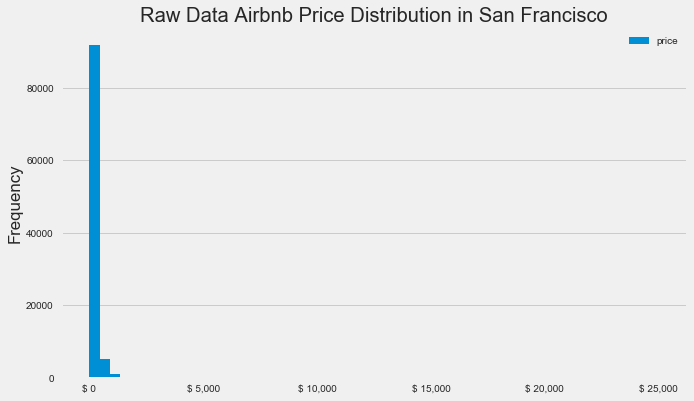

In [27]:
#Set 538 plot style
plt.style.use('fivethirtyeight')

#Airbnb price distributions
listings.price.plot(kind = 'hist', bins=55,  title='Raw Data Airbnb Price Distribution in San Francisco',
          legend = True, figsize=(10,6));

#Get axis object
ax = plt.gca()

#Format X axis
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "$ {:,}".format(int(x))))

#Mute grid lines
ax.grid(b=False, which ='major', axis = 'x')

#Set Path to write plot
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Air BnB - SF\Output Files\Visualizations\Listings Data Distributions'

#Save plot to png
#plt.savefig(path + '\Listings Raw Data Price Distribution.png',bbox_inches = 'tight')

In [28]:
print(listings.shape)

(98796, 70)


In [29]:
#Calculate IQR of price
q25 = listings['price'].quantile(0.25)
q75= listings['price'].quantile(0.75)
iqr = q75 - q25

#Print percentiles
print('Percentiles: 25th={:.3f}, 75th={:.3f} \nIQR= {:.3f}'.format(q25, q75, iqr))

#Calculate outlier cutoffs
cut_off =1.5 * iqr
lower, upper = q25 - cut_off, q75 + iqr

#Identify outliers
outliers = [x for x in listings.price if x < lower or x > upper]
print("Number of outliers identified: {}".format(len(outliers)))

#Remove outliers
outliers_removed = [x for x in listings.price if x >= lower and x <= upper]
print('Non-outlier observations: {}'.format(len(outliers_removed)))

#Update df
listings = listings[listings.price.isin(outliers_removed)]
print('Current listings shape:',listings.shape)

Percentiles: 25th=100.000, 75th=240.000 
IQR= 140.000
Number of outliers identified: 10025
Non-outlier observations: 88771
Current listings shape: (88771, 70)


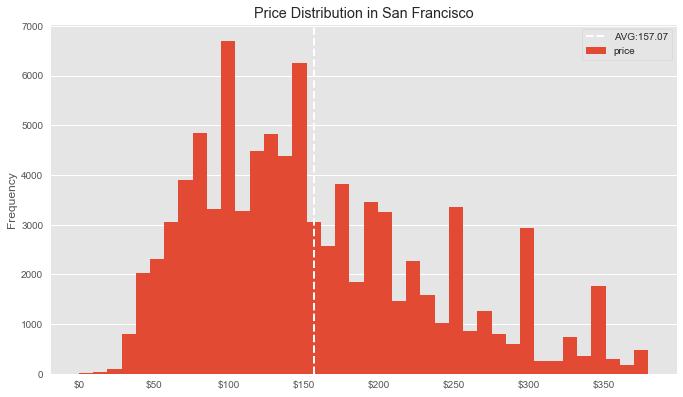

In [61]:
#Set ggplot plot style
plt.style.use('ggplot')

#Airbnb price distributions(outliers removed)
listings.price.plot(kind = 'hist', bins=40,  title='Price Distribution in San Francisco',
           figsize=(10,6));

#Capture mean and median of price
mean = listings.price.mean()
median = listings.price.median()

#Plot mean and median
plt.axvline(mean, color='white', linewidth=2, linestyle='--', label= 'AVG:'+ str(round(mean,2)))

#Get axis object
ax = plt.gca()

#Format X axis
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))

#Mute grid lines
plt.grid(b=False, which ='major', axis = 'x')

#Set legend
plt.legend(loc='upper right',frameon=True, fancybox=True)

#Save plot to png
#plt.savefig(path + '\Listings Data Price Distribution.png',bbox_inches = 'tight')

In [62]:
#Set path to write listings
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Air BnB - SF\Data\02_Intermediate\01_04_2020_Listings_Cleaned.csv'

#Write listings to path
listings.to_csv(path, sep=',')